# 1. CARGA DE LIBRERIAS

In [1]:
# Celda para importar las librerias necesarias
import numpy as np
import pandas as pd
import sklearn


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.metrics import classification_report

import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization, Activation, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.applications import VGG19, imagenet_utils
from tensorflow.keras import Model
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from tensorflow.keras.callbacks import EarlyStopping



import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Conectar con el almacenamiento de GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. CARGA DE DATOS TABULARES

In [3]:
airbnb_data_train = pd.read_csv('/content/drive/MyDrive/Keepcoding_DL/airbnb_train_cleanClass.csv', sep=';')
airbnb_data_val = pd.read_csv('/content/drive/MyDrive/Keepcoding_DL/airbnb_val_cleanClass.csv', sep=';')
airbnb_data_test = pd.read_csv('/content/drive/MyDrive/Keepcoding_DL/airbnb_test_cleanClass.csv', sep=';')

# 3. IMPLEMENTACION DE REDES NEURONALES.


## 3.1. PREPARACION DE LOS DATOS.

* Separamos la variable objetivo en los 3 datasets y las variables predictoras.
* Escalamos las variables predictoras con StandarScaler de Skelearn.

In [4]:
# Preparar carcterísticas y variable objetivo
# Dataset de train
features = airbnb_data_train.columns.drop(['Category_price'])

y_train = airbnb_data_train['Category_price'].values
X_train = airbnb_data_train[features].values

# Dataset de validation
y_val = airbnb_data_val['Category_price'].values
X_val = airbnb_data_val[features].values

# Dataset de test
y_test = airbnb_data_test['Category_price'].values
X_test = airbnb_data_test[features].values

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)
XvalScaled = scaler.transform(X_val)
XtestScaled = scaler.transform(X_test)

# Convertir etiquetas de texto a enteros
label_encoder = preprocessing.LabelEncoder()
y_train_int = label_encoder.fit_transform(y_train)
y_val_int = label_encoder.transform(y_val)
y_test_int = label_encoder.transform(y_test)

# Datos a one-hot-encoding
depth = len(label_encoder.classes_)  # Asegúrate de que el valor 'depth' sea correcto
y_train_onehot = tf.one_hot(y_train_int, depth=depth)
y_val_onehot = tf.one_hot(y_val_int, depth=depth)
y_test_onehot = tf.one_hot(y_test_int, depth=depth)

# Datos en el mismo formato
y_train = tf.cast(y_train_onehot, 'float64')
y_val = tf.cast(y_val_onehot, 'float64')
y_test = tf.cast(y_test_onehot, 'float64')

print('Datos entrenamiento: ', XtrainScaled.shape)
print('Datos de validacion: ', XvalScaled.shape)
print('Datos test: ', XtestScaled.shape)

#Hacemos lo mismo para las etiquetas.
print("El conjunto de entrenamiento (etiquetas) tiene dimensiones: ", y_train.shape)
print("El conjunto de validación (etiquetas) tiene dimensiones: ",y_val.shape)
print("El conjunto de test (etiquetas) tiene dimensiones: ",y_test.shape)


Datos entrenamiento:  (1366, 15)
Datos de validacion:  (342, 15)
Datos test:  (427, 15)
El conjunto de entrenamiento (etiquetas) tiene dimensiones:  (1366, 3)
El conjunto de validación (etiquetas) tiene dimensiones:  (342, 3)
El conjunto de test (etiquetas) tiene dimensiones:  (427, 3)


Vamos a ver que etiqueta está asociada a cada entero.

In [ ]:

# Etiqueta asociada al entero 0
label_0 = label_encoder.inverse_transform([0])[0]

# Etiqueta asociada al entero 1
label_1 = label_encoder.inverse_transform([1])[0]

# Etiqueta asociada al entero 2
label_2 = label_encoder.inverse_transform([2])[0]

# Ahora puedes imprimir las etiquetas asociadas a los enteros
print("Etiqueta asociada al entero 0:", label_0)
print("Etiqueta asociada al entero 1:", label_1)
print("Etiqueta asociada al entero 2:", label_2)


Etiqueta asociada al entero 0: Barato
Etiqueta asociada al entero 1: Caro
Etiqueta asociada al entero 2: Medio


In [ ]:
XtrainScaled

array([[-0.64291915, -0.92216487,  0.9962218 , ...,  1.0407002 ,
         1.17851369,  0.55882406],
       [-0.64291915, -0.92216487,  0.50226936, ..., -1.5807496 ,
         0.31935138, -0.88692151],
       [-0.64291915, -0.92216487,  0.00831692, ..., -0.2700247 ,
        -0.53981092, -0.01947417],
       ...,
       [-0.64291915,  0.89555117, -0.48563553, ..., -0.2700247 ,
        -0.53981092, -0.30862329],
       [-0.64291915,  0.89555117, -0.97958797, ..., -0.2700247 ,
        -0.53981092, -0.74234696],
       [-0.64291915,  0.89555117, -0.48563553, ..., -0.2700247 ,
        -0.53981092, -0.01947417]])

In [ ]:
y_train

<tf.Tensor: shape=(1366, 3), dtype=float64, numpy=
array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])>

## 3.2. CREAR FUNCION PARA IMPLEMENTAR MLP:

He creado una función a la que le vamos a pasar la función de activación, el learning rate, el decay del learning rate, el batch_size y el número de epochs. De esta forma podremos hacer cambios en estos parámetros sin tener que cambiar todo.

También definimos algunas metricas para ver que tal funciona y una gráfica que nos muestre la pérdida y las metricas seleccionadas.

Para todo esto vamos a usar Keras.

[INFO]: Entrenando red neuronal...
Epoch 1/1024
3/3 [==============================] - 1s 144ms/step - loss: 3.8401 - accuracy: 0.3748 - val_loss: 3.6604 - val_accuracy: 0.5409
Epoch 2/1024
3/3 [==============================] - 0s 36ms/step - loss: 3.6085 - accuracy: 0.5637 - val_loss: 3.5213 - val_accuracy: 0.5468
Epoch 3/1024
3/3 [==============================] - 0s 31ms/step - loss: 3.4752 - accuracy: 0.5835 - val_loss: 3.4141 - val_accuracy: 0.5409
Epoch 4/1024
3/3 [==============================] - 0s 23ms/step - loss: 3.3668 - accuracy: 0.5996 - val_loss: 3.3144 - val_accuracy: 0.5643
Epoch 5/1024
3/3 [==============================] - 0s 33ms/step - loss: 3.2639 - accuracy: 0.6127 - val_loss: 3.2173 - val_accuracy: 0.5702
Epoch 6/1024
3/3 [==============================] - 0s 35ms/step - loss: 3.1665 - accuracy: 0.6237 - val_loss: 3.1209 - val_accuracy: 0.5819
Epoch 7/1024
3/3 [==============================] - 0s 22ms/step - loss: 3.0718 - accuracy: 0.6274 - val_loss: 3.0252 

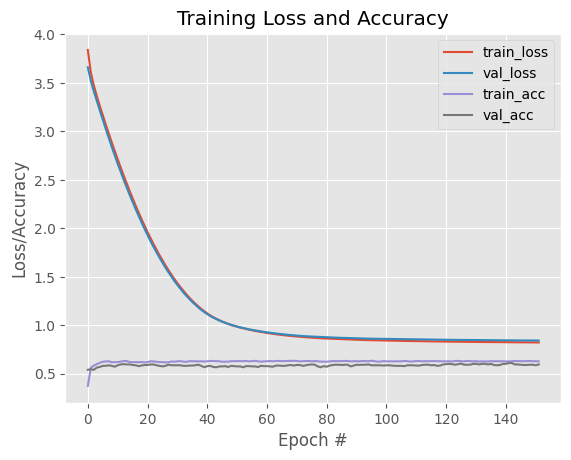

In [32]:
activation_function = tf.nn.tanh
learning_rate = 0.001
lr_decay = 1e-3
num_epochs = 1024
batch_size = 512

# Callback earlyStopping
earlyStopping_callback = keras.callbacks.EarlyStopping(
  monitor="val_loss",
  min_delta=0.001,
  patience=10)
# Modelo secuencial
model = Sequential()

model.add(Input(shape=(15,), name="capaIN"))

model.add(Dense(256, input_shape = (15,),
                activation = activation_function,
                kernel_initializer='random_uniform',
                bias_initializer='zeros',
                kernel_regularizer = l1_l2(0.001, 0.001),
                name = 'Capa1'))
model.add(Dense(128, input_shape = (256,),
                activation = activation_function,
                kernel_regularizer = l1_l2(0.001, 0.001),
                name = 'Capa2'))
model.add(Dense(32, input_shape = (128,),
                activation = activation_function,
                kernel_regularizer = l1_l2(0.001, 0.001),
                name = 'Capa3'))

model.add(Dense(3, input_shape = (32,),
                activation="softmax",
                name = 'CapaOut'))

# Compilamos y entrenamos
print("[INFO]: Entrenando red neuronal...")
loss = 'categorical_crossentropy'
metrics = ["accuracy"]
  # Implementar un callback para el decay:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=learning_rate,
    decay_steps=1000,
    decay_rate=lr_decay)

model.compile(loss=loss, optimizer=Adam(learning_rate=lr_schedule), metrics=metrics)

# Entrenando la solución
H = model.fit(XtrainScaled, y_train,
              validation_data=(XvalScaled, y_val),
              epochs=num_epochs,
              batch_size=batch_size,
              callbacks = [earlyStopping_callback])

# Evaluate the model
print("[INFO]: Evaluando red neuronal...")
preds = model.predict(XtestScaled, batch_size=batch_size)
predsTrain = model.predict(XtrainScaled, batch_size=batch_size)
predsVal =  model.predict(XvalScaled, batch_size=batch_size)
predictions = np.argmax(preds, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print(classification_report(y_test_labels,
                            predictions,
                            digits=3))

np.save('/content/drive/MyDrive/Keepcoding_DL/predsMLPTrainClass.npy', predsTrain)
np.save('/content/drive/MyDrive/Keepcoding_DL/predsMLPValClass.npy', predsVal)
np.save('/content/drive/MyDrive/Keepcoding_DL/predsMLPTestClass.npy', preds)

# Muestro gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(H.history["loss"])), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, len(H.history["val_loss"])), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, len(H.history["accuracy"])), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, len(H.history["val_accuracy"])), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


Despues de varias pruebas cambiando funciones, learning rate, decay etc... esta es la mejor combinación que he conseguido y que al menos reconce las 3 clases.

# 4. TRATAMIENTO DE DATOS DE IMAGEN

## 4.1. CARGA DE IMAGENES

In [ ]:
data_imagen = np.load('/content/drive/MyDrive/Keepcoding_DL/images_KC.npy')

# Cargar los índices desde archivos npy
index_train_loaded = np.load('/content/drive/MyDrive/Keepcoding_DL/index_train.npy')
index_val_loaded = np.load('/content/drive/MyDrive/Keepcoding_DL/index_val.npy')
index_test_loaded = np.load('/content/drive/MyDrive/Keepcoding_DL/index_test.npy')

# Convertirlos a índices de pandas
index_train = pd.Index(index_train_loaded)
index_val  = pd.Index(index_val_loaded)
index_test = pd.Index(index_test_loaded)

# Verificar las formas de los datos
print('Shape de las imágenes:', data_imagen.shape)
X_train_pic = data_imagen[index_train]
X_val_pic = data_imagen[index_val]
X_test_pic = data_imagen[index_test]
y_train_lab = y_train
y_val_lab = y_val
y_test_lab = y_test

print('Shape de imagenes_train:', X_train_pic.shape)
print('Shape de labels_train:', y_train_lab.shape)
print('Shape de imagenes_val:', X_val_pic.shape)
print('Shape de labels_val:', y_val_lab.shape)
print('Shape de imagenes_test:', X_test_pic.shape)
print('Shape de labels_test:', y_test_lab.shape)

Shape de las imágenes: (2135, 224, 224, 3)
Shape de imagenes_train: (1366, 224, 224, 3)
Shape de labels_train: (1366, 3)
Shape de imagenes_val: (342, 224, 224, 3)
Shape de labels_val: (342, 3)
Shape de imagenes_test: (427, 224, 224, 3)
Shape de labels_test: (427, 3)


## 4.2. IMPLEMENTACION CNN

In [ ]:
# definimos la función para entrenar nuestra red con los parámetros deseados
def train_image1(activation_function, learning_rate, lr_decay, batch_size, num_epochs):
    # Callback earlyStopping
    earlyStopping_callback = EarlyStopping(
        monitor="val_loss",
        min_delta=0.001,
        patience=5
    )

    # Implement the model using Keras
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     input_shape=(224, 224, 3),
                     name='COVTI1_1'))
    model.add(BatchNormalization())
    model.add(Activation(activation_function))
    model.add(Conv2D(filters=32, kernel_size=(3, 3),
                     activation=activation_function,
                     name='COVTI1_2'))
    model.add(Conv2D(filters=16, kernel_size=(3, 3),
                  activation=activation_function,
                  name='COVTI1_3'))
    model.add(Flatten())
    model.add(Dense(32, activation=activation_function, name='TI1_1'))
    model.add(Dense(3, activation="softmax", name='TI1Out'))

    # Compile and train the model using SGD
    print("[INFO]: Entrenando red neuronal...")
    loss = 'categorical_crossentropy'
    metrics = ["accuracy"]

    # Implement a callback for the decay
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        initial_learning_rate=learning_rate,
        decay_steps=10,
        decay_rate=lr_decay
    )

    model.compile(loss=loss,
                  optimizer=Adam(learning_rate=lr_schedule),
                  metrics=metrics)

    # Train the model
    H = model.fit(X_train_pic, y_train_lab,
                  validation_data=(X_val_pic, y_val_lab),
                  epochs=num_epochs, batch_size=batch_size,
                  callbacks=[earlyStopping_callback])

    # Evaluate the model
    print("[INFO]: Evaluando red neuronal...")
    predictions = model.predict(X_test_pic, batch_size=batch_size)
    predsCNNTrain = model.predict(X_train_pic, batch_size=batch_size)
    predsCNNVal = model.predict(X_val_pic, batch_size=batch_size)

    # Guardar las predicciones para usarlas posteriormente en Late Fusion
    np.save('/content/drive/MyDrive/Keepcoding_DL/predsCNNTrainClass.npy', predsCNNTrain)
    np.save('/content/drive/MyDrive/Keepcoding_DL/predsCNNValClass.npy', predsCNNVal)
    np.save('/content/drive/MyDrive/Keepcoding_DL/predsCNNTestClass.npy', predictions)

    predictions = np.argmax(predictions, axis=1)
    y_test_labels = np.argmax(y_test_lab, axis=1)

    print(classification_report(y_test_labels, predictions, digits=3))

    # Plot accuracy and losses
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, len(H.history["loss"])), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, len(H.history["val_loss"])), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, len(H.history["accuracy"])), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, len(H.history["val_accuracy"])), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()


## 4.3. ENTRENAR MODELO

[INFO]: Entrenando red neuronal...
Epoch 1/50
11/11 [==============================] - 48s 2s/step - loss: 2.1841 - accuracy: 0.3477 - val_loss: 2.1708 - val_accuracy: 0.3567
Epoch 2/50
11/11 [==============================] - 7s 637ms/step - loss: 2.1302 - accuracy: 0.3411 - val_loss: 1.9900 - val_accuracy: 0.3567
Epoch 3/50
11/11 [==============================] - 7s 639ms/step - loss: 1.9485 - accuracy: 0.3411 - val_loss: 1.8204 - val_accuracy: 0.3567
Epoch 4/50
11/11 [==============================] - 7s 670ms/step - loss: 1.7812 - accuracy: 0.3411 - val_loss: 1.6669 - val_accuracy: 0.3567
Epoch 5/50
11/11 [==============================] - 7s 640ms/step - loss: 1.6318 - accuracy: 0.3411 - val_loss: 1.5330 - val_accuracy: 0.3567
Epoch 6/50
11/11 [==============================] - 8s 717ms/step - loss: 1.5051 - accuracy: 0.3411 - val_loss: 1.4199 - val_accuracy: 0.3567
Epoch 7/50
11/11 [==============================] - 8s 699ms/step - loss: 1.3967 - accuracy: 0.3411 - val_loss: 1.3

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


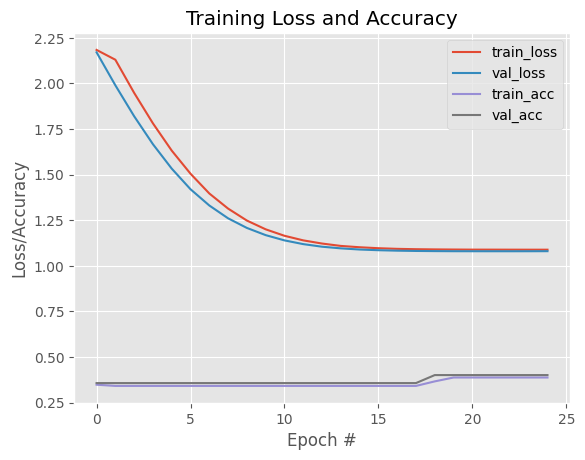

In [ ]:
activation_function = tf.nn.sigmoid
learning_rate = 0.001
lr_decay = 0.001
num_epochs = 50
batch_size = 128
train_image1(activation_function, learning_rate, lr_decay, batch_size, num_epochs)

[INFO]: Entrenando red neuronal...
Epoch 1/50
11/11 [==============================] - 20s 1s/step - loss: 338.4524 - accuracy: 0.2965 - val_loss: 1.1006 - val_accuracy: 0.4006
Epoch 2/50
11/11 [==============================] - 7s 620ms/step - loss: 1.1024 - accuracy: 0.3873 - val_loss: 1.0961 - val_accuracy: 0.4006
Epoch 3/50
11/11 [==============================] - 7s 598ms/step - loss: 1.0950 - accuracy: 0.3873 - val_loss: 1.0908 - val_accuracy: 0.4006
Epoch 4/50
11/11 [==============================] - 7s 625ms/step - loss: 1.0917 - accuracy: 0.3873 - val_loss: 1.0868 - val_accuracy: 0.4006
Epoch 5/50
11/11 [==============================] - 7s 614ms/step - loss: 1.0900 - accuracy: 0.3873 - val_loss: 1.0836 - val_accuracy: 0.4006
Epoch 6/50
11/11 [==============================] - 7s 610ms/step - loss: 1.0889 - accuracy: 0.3873 - val_loss: 1.0819 - val_accuracy: 0.4006
Epoch 7/50
11/11 [==============================] - 7s 596ms/step - loss: 1.0885 - accuracy: 0.3873 - val_loss: 1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.000     0.000     0.000       130
           1      0.000     0.000     0.000       127
           2      0.398     1.000     0.570       170

    accuracy                          0.398       427
   macro avg      0.133     0.333     0.190       427
weighted avg      0.159     0.398     0.227       427



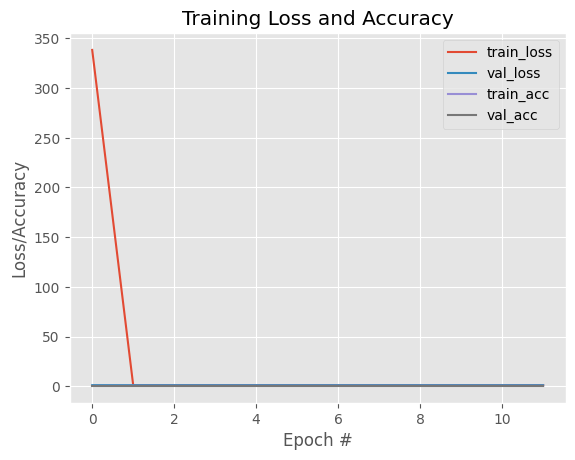

In [ ]:
activation_function = tf.nn.relu
learning_rate = 0.01
lr_decay = 0.001
num_epochs = 50
batch_size = 128
train_image1(activation_function, learning_rate, lr_decay, batch_size, num_epochs)

[INFO]: Entrenando red neuronal...
Epoch 1/50
11/11 [==============================] - 10s 744ms/step - loss: 2.1321 - accuracy: 0.3411 - val_loss: 1.2994 - val_accuracy: 0.3596
Epoch 2/50
11/11 [==============================] - 7s 642ms/step - loss: 1.3706 - accuracy: 0.3829 - val_loss: 1.2925 - val_accuracy: 0.3860
Epoch 3/50
11/11 [==============================] - 8s 724ms/step - loss: 1.4090 - accuracy: 0.3455 - val_loss: 1.2008 - val_accuracy: 0.4035
Epoch 4/50
11/11 [==============================] - 7s 651ms/step - loss: 1.4308 - accuracy: 0.3419 - val_loss: 1.1475 - val_accuracy: 0.3743
Epoch 5/50
11/11 [==============================] - 7s 663ms/step - loss: 1.2665 - accuracy: 0.3580 - val_loss: 1.1380 - val_accuracy: 0.3363
Epoch 6/50
11/11 [==============================] - 7s 647ms/step - loss: 1.1927 - accuracy: 0.3851 - val_loss: 1.1844 - val_accuracy: 0.2953
Epoch 7/50
11/11 [==============================] - 7s 656ms/step - loss: 1.1850 - accuracy: 0.3836 - val_loss: 

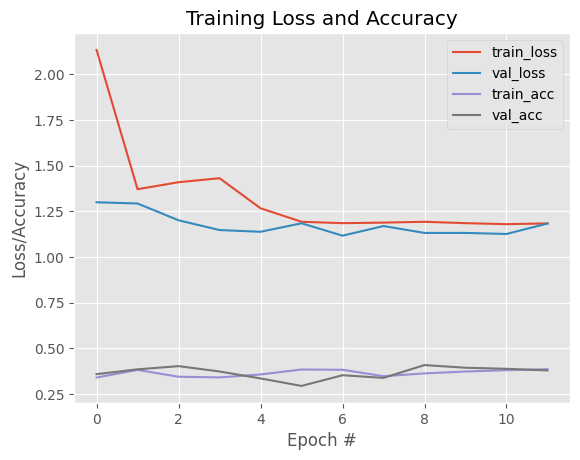

In [ ]:
activation_function = tf.nn.tanh
learning_rate = 0.001
lr_decay = 0.001
num_epochs = 50
batch_size = 128
train_image1(activation_function, learning_rate, lr_decay, batch_size, num_epochs)

Observo cierto problema para clasificar las clases 0 y 1 (BARATO Y CARO), clasifica mejor con el valor 2 (MEDIO)

## 4.4 MODELO CON RED PREENTRENADA (VGG19)

### 4.4.1. CARGA DATOS

Voy a cargar los datos devolverlos a su estado original y procesarlos con el procesamiento de VGG19.

In [5]:
data_imagen = np.load('/content/drive/MyDrive/Keepcoding_DL/images_KC.npy')

data_imagen = data_imagen *255

preprocess = imagenet_utils.preprocess_input

data_imagen = preprocess(data_imagen)

# Cargar los índices desde archivos npy
index_train_loaded = np.load('/content/drive/MyDrive/Keepcoding_DL/index_train.npy')
index_val_loaded = np.load('/content/drive/MyDrive/Keepcoding_DL/index_val.npy')
index_test_loaded = np.load('/content/drive/MyDrive/Keepcoding_DL/index_test.npy')

# Convertirlos a índices de pandas
index_train = pd.Index(index_train_loaded)
index_val  = pd.Index(index_val_loaded)
index_test = pd.Index(index_test_loaded)
X_train_pic = data_imagen[index_train]
X_val_pic = data_imagen[index_val]
X_test_pic = data_imagen[index_test]

y_train_lab = y_train
y_val_lab = y_val
y_test_lab = y_test

print('Shape de imagenes_train:', X_train_pic.shape)
print('Shape de labels_train:', y_train_lab.shape)
print('Shape de imagenes_val:', X_val_pic.shape)
print('Shape de labels_val:', y_val_lab.shape)
print('Shape de imagenes_test:', X_test_pic.shape)
print('Shape de labels_test:', y_test_lab.shape)

Shape de imagenes_train: (1366, 224, 224, 3)
Shape de labels_train: (1366, 3)
Shape de imagenes_val: (342, 224, 224, 3)
Shape de labels_val: (342, 3)
Shape de imagenes_test: (427, 224, 224, 3)
Shape de labels_test: (427, 3)


### 4.4.2. IMPLEMENTACION CNN CON RED PREENTRENADA

In [14]:
def train_image2(activation_function, learning_rate, lr_decay, batch_size, num_epochs):
  input_shape = (224, 224, 3)
  # Callback earlyStopping
  earlyStopping_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5)

  base_model = VGG19(weights='imagenet',
                     include_top=False,
                     input_shape=input_shape)

  for layer in base_model.layers:
    layer.trainable = False
    print('Capa ' + layer.name + ' congelada.')

  last = base_model.layers[-1].output
  x = GlobalAveragePooling2D()(last)
  x = Dense(64, activation=activation_function,
                    name = 'D1')(x)
  x = Dense(32, activation=activation_function,
                    name = 'D2')(x)
  x = Dense(16, activation=activation_function,
                    name = 'D3')(x)
  x = Dense(3, activation="softmax",  name = 'DOut')(x)

  model = Model(base_model.input, x)

  # Compilamos y entrenamos el modelo SGD
  print("[INFO]: Entrenando red neuronal...")
  loss = 'categorical_crossentropy'
  metrics = ['accuracy']
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=learning_rate,
      decay_steps=1000,
      decay_rate=lr_decay)
  model.compile(loss= loss,
                  optimizer=Adam(lr_schedule),
                  metrics= metrics)

  H = model.fit(X_train_pic, y_train_lab,
                validation_data=(X_val_pic, y_val_lab),
                epochs=num_epochs, batch_size=batch_size,
                callbacks = ([earlyStopping_callback]))

  print("[INFO]: Evaluando red neuronal...")
  preds = model.predict(X_test_pic, batch_size=batch_size)
  predsCNNTrain = model.predict(X_train_pic, batch_size=batch_size)
  predsCNNVal = model.predict(X_val_pic, batch_size=batch_size)

  # Guardar las predicciones para usarlas posteriormente en Late Fusion
  np.save('/content/drive/MyDrive/Keepcoding_DL/predsCNNTrainClass.npy', predsCNNTrain)
  np.save('/content/drive/MyDrive/Keepcoding_DL/predsCNNValClass.npy', predsCNNVal)
  np.save('/content/drive/MyDrive/Keepcoding_DL/predsCNNTestClass.npy', preds)

  # Evaluate the model
  print("[INFO]: Evaluando red neuronal...")
  predictions = np.argmax(preds, axis=1)
  y_test_labels = np.argmax(y_test_lab, axis=1)

  print(classification_report(y_test_labels, predictions, digits=3))

  # Plot accuracy and losses
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, len(H.history["loss"])), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, len(H.history["val_loss"])), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, len(H.history["accuracy"])), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, len(H.history["val_accuracy"])), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()


Capa input_6 congelada.
Capa block1_conv1 congelada.
Capa block1_conv2 congelada.
Capa block1_pool congelada.
Capa block2_conv1 congelada.
Capa block2_conv2 congelada.
Capa block2_pool congelada.
Capa block3_conv1 congelada.
Capa block3_conv2 congelada.
Capa block3_conv3 congelada.
Capa block3_conv4 congelada.
Capa block3_pool congelada.
Capa block4_conv1 congelada.
Capa block4_conv2 congelada.
Capa block4_conv3 congelada.
Capa block4_conv4 congelada.
Capa block4_pool congelada.
Capa block5_conv1 congelada.
Capa block5_conv2 congelada.
Capa block5_conv3 congelada.
Capa block5_conv4 congelada.
Capa block5_pool congelada.
[INFO]: Entrenando red neuronal...
Epoch 1/100
6/6 [==============================] - 11s 2s/step - loss: 1.5285 - accuracy: 0.3646 - val_loss: 1.1194 - val_accuracy: 0.3860
Epoch 2/100
6/6 [==============================] - 8s 1s/step - loss: 1.1198 - accuracy: 0.3836 - val_loss: 1.0930 - val_accuracy: 0.3626
Epoch 3/100
6/6 [==============================] - 9s 1s/ste

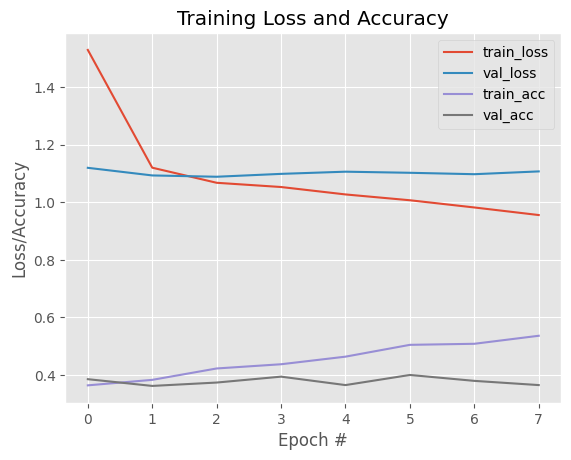

In [ ]:
  activation_function = tf.nn.relu
  num_epochs = 100
  batch_size = 256
  learning_rate = 0.001
  lr_decay = 1e-3
  train_image2(activation_function, learning_rate, lr_decay, batch_size, num_epochs)

Capa input_7 congelada.
Capa block1_conv1 congelada.
Capa block1_conv2 congelada.
Capa block1_pool congelada.
Capa block2_conv1 congelada.
Capa block2_conv2 congelada.
Capa block2_pool congelada.
Capa block3_conv1 congelada.
Capa block3_conv2 congelada.
Capa block3_conv3 congelada.
Capa block3_conv4 congelada.
Capa block3_pool congelada.
Capa block4_conv1 congelada.
Capa block4_conv2 congelada.
Capa block4_conv3 congelada.
Capa block4_conv4 congelada.
Capa block4_pool congelada.
Capa block5_conv1 congelada.
Capa block5_conv2 congelada.
Capa block5_conv3 congelada.
Capa block5_conv4 congelada.
Capa block5_pool congelada.
[INFO]: Entrenando red neuronal...
Epoch 1/100
6/6 [==============================] - 12s 2s/step - loss: 1.1689 - accuracy: 0.3660 - val_loss: 1.1134 - val_accuracy: 0.3977
Epoch 2/100
6/6 [==============================] - 9s 2s/step - loss: 1.0530 - accuracy: 0.4356 - val_loss: 1.1046 - val_accuracy: 0.4152
Epoch 3/100
6/6 [==============================] - 9s 1s/ste

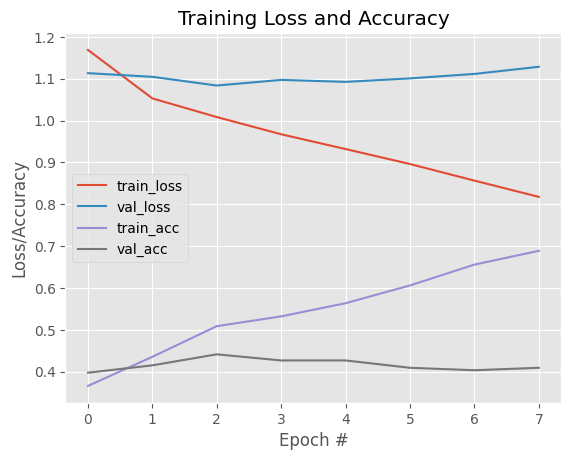

In [ ]:
activation_function = tf.nn.tanh
num_epochs = 100
batch_size = 256
learning_rate = 0.001
lr_decay = 1e-4
train_image2(activation_function, learning_rate, lr_decay, batch_size, num_epochs)

Capa input_8 congelada.
Capa block1_conv1 congelada.
Capa block1_conv2 congelada.
Capa block1_pool congelada.
Capa block2_conv1 congelada.
Capa block2_conv2 congelada.
Capa block2_pool congelada.
Capa block3_conv1 congelada.
Capa block3_conv2 congelada.
Capa block3_conv3 congelada.
Capa block3_conv4 congelada.
Capa block3_pool congelada.
Capa block4_conv1 congelada.
Capa block4_conv2 congelada.
Capa block4_conv3 congelada.
Capa block4_conv4 congelada.
Capa block4_pool congelada.
Capa block5_conv1 congelada.
Capa block5_conv2 congelada.
Capa block5_conv3 congelada.
Capa block5_conv4 congelada.
Capa block5_pool congelada.
[INFO]: Entrenando red neuronal...
Epoch 1/100
6/6 [==============================] - 12s 2s/step - loss: 1.1042 - accuracy: 0.3192 - val_loss: 1.0851 - val_accuracy: 0.4006
Epoch 2/100
6/6 [==============================] - 8s 1s/step - loss: 1.0885 - accuracy: 0.3873 - val_loss: 1.0779 - val_accuracy: 0.4006
Epoch 3/100
6/6 [==============================] - 9s 2s/ste

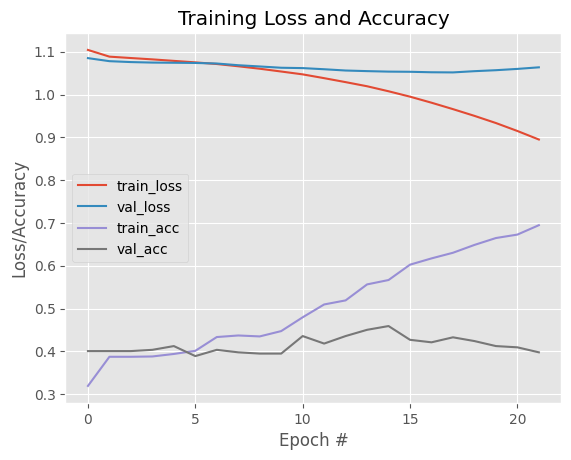

In [ ]:
activation_function = tf.nn.sigmoid
num_epochs = 100
batch_size = 256
learning_rate = 0.001
lr_decay = 1e-4
train_image2(activation_function, learning_rate, lr_decay, batch_size, num_epochs)

### 4.4.3 LIBERAR MAS CAPAS

Liberar la ultima capa.


In [11]:
def train_image3(activation_function, learning_rate, lr_decay, batch_size, num_epochs):
  input_shape = (224, 224, 3)
  # Callback earlyStopping
  earlyStopping_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5)

  base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
  for layer in base_model.layers:
    if layer.name == 'block5_conv1':
      break
    layer.trainable = False
    print('Capa ' + layer.name + ' congelada.')

  last = base_model.layers[-1].output
  x = GlobalAveragePooling2D()(last)
  x = Dense(64, activation=activation_function,
            kernel_regularizer= l1_l2(0.01, 0.01),
                    name = 'D1')(x)
  x = Dense(32, activation=activation_function,
            kernel_regularizer= l1_l2(0.01, 0.01),
                    name = 'D2')(x)
  x = Dense(3, activation="softmax",  name = 'DOut')(x)

  model = Model(base_model.input, x)

   # Compile and train the model using SGD
  print("[INFO]: Entrenando red neuronal...")
  loss = 'categorical_crossentropy'
  metrics = ["accuracy"]

  # Implement a callback for the decay
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=learning_rate,
      decay_steps=10,
      decay_rate=lr_decay
  )

  model.compile(loss=loss,
                optimizer=Adam(learning_rate=lr_schedule),
                metrics=metrics)


  H = model.fit(X_train_pic, y_train_lab,
                validation_data=(X_val_pic, y_val_lab),
                epochs=num_epochs,
                batch_size=batch_size,
                callbacks=[earlyStopping_callback])

  print("[INFO]: Evaluando red neuronal...")
  preds = model.predict(X_test_pic, batch_size=batch_size)
  predsCNNTrain = model.predict(X_train_pic, batch_size=batch_size)
  predsCNNVal = model.predict(X_val_pic, batch_size=batch_size)

  # Guardar las predicciones para usarlas posteriormente en Late Fusion
  np.save('/content/drive/MyDrive/Keepcoding_DL/predsCNNTrainClass.npy', predsCNNTrain)
  np.save('/content/drive/MyDrive/Keepcoding_DL/predsCNNValClass.npy', predsCNNVal)
  np.save('/content/drive/MyDrive/Keepcoding_DL/predsCNNTestClass.npy', preds)

  # Evaluate the model
  print("[INFO]: Evaluando red neuronal...")
  predictions = np.argmax(preds, axis=1)
  y_test_labels = np.argmax(y_test_lab, axis=1)

  print(classification_report(y_test_labels, predictions, digits=3))

  # Plot accuracy and losses
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, len(H.history["loss"])), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, len(H.history["val_loss"])), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, len(H.history["accuracy"])), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, len(H.history["val_accuracy"])), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()

Capa input_3 congelada.
Capa block1_conv1 congelada.
Capa block1_conv2 congelada.
Capa block1_pool congelada.
Capa block2_conv1 congelada.
Capa block2_conv2 congelada.
Capa block2_pool congelada.
Capa block3_conv1 congelada.
Capa block3_conv2 congelada.
Capa block3_conv3 congelada.
Capa block3_conv4 congelada.
Capa block3_pool congelada.
Capa block4_conv1 congelada.
Capa block4_conv2 congelada.
Capa block4_conv3 congelada.
Capa block4_conv4 congelada.
Capa block4_pool congelada.
[INFO]: Entrenando red neuronal...
Epoch 1/100
6/6 [==============================] - 13s 2s/step - loss: 21.8310 - accuracy: 0.3485 - val_loss: 20.4060 - val_accuracy: 0.3567
Epoch 2/100
6/6 [==============================] - 11s 2s/step - loss: 19.6786 - accuracy: 0.3192 - val_loss: 18.3260 - val_accuracy: 0.3567
Epoch 3/100
6/6 [==============================] - 11s 2s/step - loss: 17.7083 - accuracy: 0.3433 - val_loss: 16.5867 - val_accuracy: 0.4006
Epoch 4/100
6/6 [==============================] - 10s 2s/

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


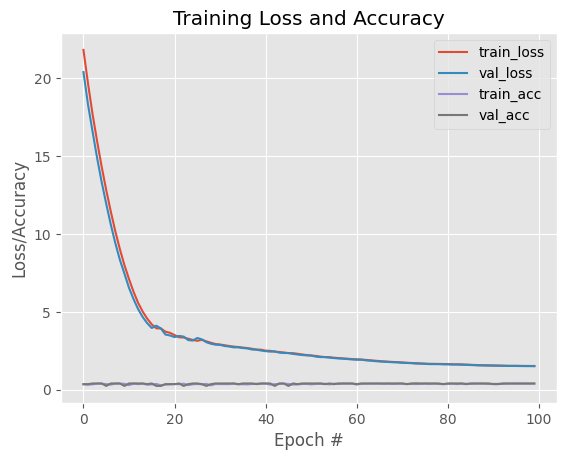

In [12]:
  activation_function = tf.nn.tanh
  num_epochs = 100
  batch_size = 256
  learning_rate = 0.001
  lr_decay = 1e-4
  train_image3(activation_function, learning_rate, lr_decay, batch_size, num_epochs)

Me quedo con la opción:
activation_function = tf.nn.tanh

num_epochs = 100

batch_size = 256

learning_rate = 0.001

lr_decay = 1e-4

train_image2(activation_function, learning_rate, lr_decay, batch_size, num_epochs)

Que sin ser muy buenos los resultados al menos reconoce las 3 clases.

Capa input_4 congelada.
Capa block1_conv1 congelada.
Capa block1_conv2 congelada.
Capa block1_pool congelada.
Capa block2_conv1 congelada.
Capa block2_conv2 congelada.
Capa block2_pool congelada.
Capa block3_conv1 congelada.
Capa block3_conv2 congelada.
Capa block3_conv3 congelada.
Capa block3_conv4 congelada.
Capa block3_pool congelada.
Capa block4_conv1 congelada.
Capa block4_conv2 congelada.
Capa block4_conv3 congelada.
Capa block4_conv4 congelada.
Capa block4_pool congelada.
Capa block5_conv1 congelada.
Capa block5_conv2 congelada.
Capa block5_conv3 congelada.
Capa block5_conv4 congelada.
Capa block5_pool congelada.
[INFO]: Entrenando red neuronal...
Epoch 1/100
6/6 [==============================] - 13s 2s/step - loss: 1.1382 - accuracy: 0.3712 - val_loss: 1.1219 - val_accuracy: 0.3801
Epoch 2/100
6/6 [==============================] - 10s 2s/step - loss: 1.0254 - accuracy: 0.4832 - val_loss: 1.0949 - val_accuracy: 0.4006
Epoch 3/100
6/6 [==============================] - 10s 2s/s

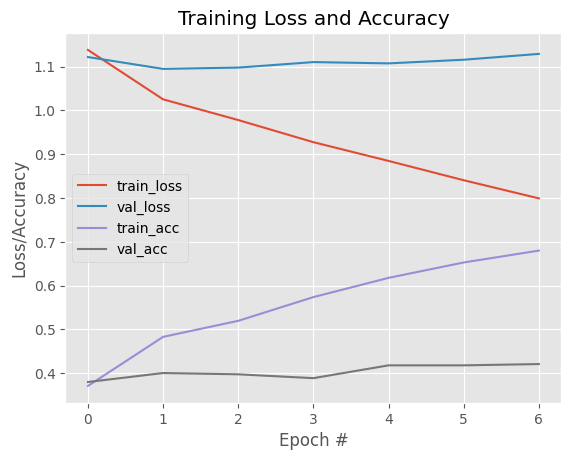

In [15]:
activation_function = tf.nn.tanh
num_epochs = 100
batch_size = 256
learning_rate = 0.001
lr_decay = 1e-4
train_image2(activation_function, learning_rate, lr_decay, batch_size, num_epochs)

# 5. LATE FUSION

## 5.1. CARGAR PREDICCIONES

In [34]:
# Cargar las predicciones guardadas

predsMLPTrain = np.load('/content/drive/MyDrive/Keepcoding_DL/predsMLPTrainClass.npy')
predsCNNTrain = np.load('/content/drive/MyDrive/Keepcoding_DL/predsCNNTrainClass.npy')

predsMLPVal = np.load('/content/drive/MyDrive/Keepcoding_DL/predsMLPValClass.npy')
predsCNNVal = np.load('/content/drive/MyDrive/Keepcoding_DL/predsCNNValClass.npy')

predsMLPTest = np.load('/content/drive/MyDrive/Keepcoding_DL/predsMLPTestClass.npy')
predsCNNTest = np.load('/content/drive/MyDrive/Keepcoding_DL/predsCNNTestClass.npy')
# Concatenar las predicciones

features_late_fusion_train = np.concatenate((predsMLPTrain, predsCNNTrain), axis=1)
features_late_fusion_val = np.concatenate((predsMLPVal, predsCNNVal), axis=1)
features_late_fusion_test = np.concatenate((predsMLPTest, predsCNNTest), axis=1)

## 5.2. MODELO COMBINADO

In [35]:
# Definir el modelo de late fusion
earlyStopping_callback = keras.callbacks.EarlyStopping(
  monitor="val_loss",
  min_delta=0.001,
  patience=10,
)
model_fusion = Sequential([
    Input(shape=(6,), name="LF2IN"),
    Dense(512, activation='relu',
          name='LF2_1'),
    Dense(256, activation='relu',
          name='LF2_2'),
    Dense(128, activation='relu',
          name='LF2_3'),
    Dense(64, activation='relu',
          name='LF2_4'),
    Dense(3, activation="softmax", name='LF2Out')
])
loss = 'categorical_crossentropy'
metrics = ['accuracy']

lr_schedule_fusion = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.001,
    decay_steps=1,
    decay_rate=1e-3
)

model_fusion.compile(loss=loss,
                     optimizer=Adam(learning_rate=lr_schedule_fusion),
                     metrics=metrics
                     )

H_fusion = model_fusion.fit(features_late_fusion_train,
                            y_train_lab,
                            epochs=256,
                            batch_size=256,
                            validation_data=(features_late_fusion_val, y_val_lab),
                            callbacks=[earlyStopping_callback])

# Evaluar el modelo de fusión
preds_fusion = model_fusion.predict(features_late_fusion_test, batch_size=256)

Epoch 1/256
6/6 [==============================] - 5s 109ms/step - loss: 1.0572 - accuracy: 0.5556 - val_loss: 1.0082 - val_accuracy: 0.5322
Epoch 2/256
6/6 [==============================] - 0s 48ms/step - loss: 0.8824 - accuracy: 0.7643 - val_loss: 0.8947 - val_accuracy: 0.5556
Epoch 3/256
6/6 [==============================] - 0s 29ms/step - loss: 0.6551 - accuracy: 0.7789 - val_loss: 0.9279 - val_accuracy: 0.5380
Epoch 4/256
6/6 [==============================] - 0s 18ms/step - loss: 0.5414 - accuracy: 0.7855 - val_loss: 1.1507 - val_accuracy: 0.5117
Epoch 5/256
6/6 [==============================] - 0s 25ms/step - loss: 0.5286 - accuracy: 0.7914 - val_loss: 1.2658 - val_accuracy: 0.5146
Epoch 6/256
6/6 [==============================] - 0s 9ms/step - loss: 0.5279 - accuracy: 0.7877 - val_loss: 1.2584 - val_accuracy: 0.4883
Epoch 7/256
6/6 [==============================] - 0s 9ms/step - loss: 0.5202 - accuracy: 0.8001 - val_loss: 1.2373 - val_accuracy: 0.4854
Epoch 8/256
6/6 [====

## 5.3. EVALUAR MODELO

              precision    recall  f1-score   support

           0      0.607     0.546     0.575       130
           1      0.602     0.606     0.604       127
           2      0.456     0.488     0.472       170

    accuracy                          0.541       427
   macro avg      0.555     0.547     0.550       427
weighted avg      0.545     0.541     0.542       427



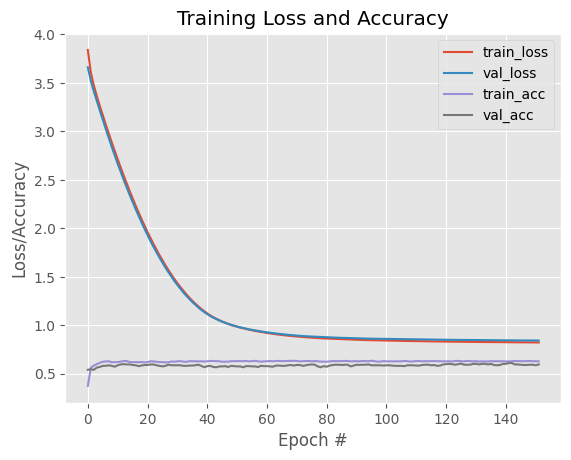

In [36]:
# Evaluate the model
predictions = np.argmax(preds_fusion, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print(classification_report(y_test_labels, predictions, digits=3))

# Plot accuracy and losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(H.history["loss"])), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, len(H.history["val_loss"])), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, len(H.history["accuracy"])), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, len(H.history["val_accuracy"])), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# 6. EARLY FUSION

## 6.1 IMPLEMENTAR RED PREENTRENADA

In [37]:
input_shape = (224, 224, 3)
classifier2D = VGG19(weights='imagenet',
                     include_top=False,
                     input_shape=input_shape)
last_conv = classifier2D.layers[-2].output
last_conv_globalAvg = GlobalAveragePooling2D()(last_conv)
feature_extractor = Model(classifier2D.input, last_conv_globalAvg)

loss = 'categorical_crossentropy'
metrics = ['accuracy']
lr_schedule_cnn = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=1e-4
)

8.2. UNIR DATOS TABULARES E IMAGENES

In [38]:
# Extraer características del conjunto de datos de imágenes
features_train = feature_extractor.predict(X_train_pic, batch_size=256)
features_val = feature_extractor.predict(X_val_pic, batch_size=256)
features_test = feature_extractor.predict(X_test_pic, batch_size=256)
# Concatenar características de imágenes con datos tabulares
X_train_combined = np.concatenate([XtrainScaled, features_train], axis=1)
X_val_combined = np.concatenate([XvalScaled, features_val], axis=1)
X_test_combined = np.concatenate([XtestScaled, features_test], axis=1)

2/2 [==============================] - 2s 1s/step


## 6.2. MODELADO COMBINADO

In [67]:
# Definir el modelo combinado
earlyStopping_callback = keras.callbacks.EarlyStopping(
  monitor="val_loss",
  min_delta=0.001,
  patience=10,
)
input_shape = X_train_combined.shape[1]

model_combined = Sequential([
    Input(shape=(input_shape,), name="LF1IN"),
    Dense(128,
          kernel_initializer='random_uniform',
          bias_initializer='zeros',
          kernel_regularizer=l1_l2(0.001,0.001),
          name='LF1_1'),
    BatchNormalization(),
    Activation(activation='relu'),
    Dropout(0.2),
    Dense(64,
          kernel_regularizer=l1_l2(0.001,0.001),
          name='LNF1_2'),
    BatchNormalization(),
    Activation(activation='relu'),
    Dropout(0.2),
    Dense(32,
          kernel_regularizer=l1_l2(0.001,0.001),
          name='LNF1_3'),
    BatchNormalization(),
    Activation(activation='relu'),
    Dense(3, activation="softmax",
          name='TNF1Out')
])
loss = 'categorical_crossentropy'
metrics = ['accuracy']

lr_schedule_fusionEF = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=1e-4
)

model_combined.compile(loss=loss,
                     optimizer=Adam(learning_rate=lr_schedule_fusionEF),
                     metrics=metrics
                     )

H_fusion = model_combined.fit(X_train_combined,
                            y_train_lab,
                            epochs=256,
                            batch_size=256,
                            validation_data=(X_val_combined, y_val_lab),
                            callbacks=[earlyStopping_callback])

Epoch 1/256
6/6 [==============================] - 5s 119ms/step - loss: 3.8989 - accuracy: 0.4129 - val_loss: 3.8364 - val_accuracy: 0.4064
Epoch 2/256
6/6 [==============================] - 0s 15ms/step - loss: 3.5879 - accuracy: 0.5088 - val_loss: 3.6162 - val_accuracy: 0.4474
Epoch 3/256
6/6 [==============================] - 0s 14ms/step - loss: 3.1185 - accuracy: 0.6091 - val_loss: 3.0409 - val_accuracy: 0.4795
Epoch 4/256
6/6 [==============================] - 0s 13ms/step - loss: 2.5987 - accuracy: 0.6654 - val_loss: 2.6276 - val_accuracy: 0.4620
Epoch 5/256
6/6 [==============================] - 0s 12ms/step - loss: 2.2112 - accuracy: 0.7101 - val_loss: 2.4039 - val_accuracy: 0.4620
Epoch 6/256
6/6 [==============================] - 0s 12ms/step - loss: 1.9882 - accuracy: 0.7284 - val_loss: 2.2934 - val_accuracy: 0.4912
Epoch 7/256
6/6 [==============================] - 0s 11ms/step - loss: 1.9071 - accuracy: 0.7321 - val_loss: 2.2627 - val_accuracy: 0.4971
Epoch 8/256
6/6 [==

## 6.3. EVALUACION DEL MODELO

2/2 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0      0.583     0.623     0.602       130
           1      0.625     0.276     0.383       127
           2      0.457     0.624     0.527       170

    accuracy                          0.520       427
   macro avg      0.555     0.507     0.504       427
weighted avg      0.545     0.520     0.507       427



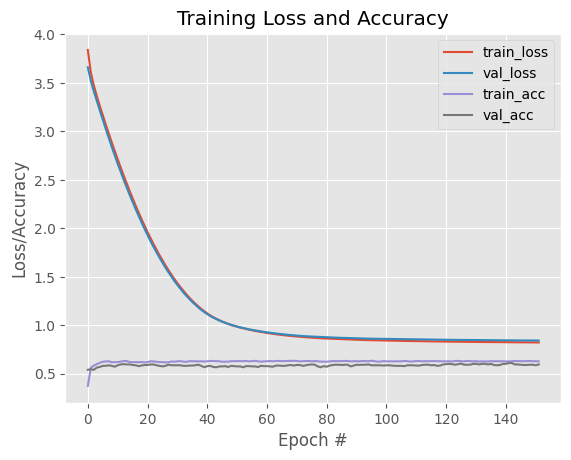

In [68]:
# Evaluar el modelo combinado con el conjunto de prueba
preds_combined = model_combined.predict(X_test_combined, batch_size=256)
predictions = np.argmax(preds_combined, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print(classification_report(y_test_labels, predictions, digits=3))

# Plot accuracy and losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(H.history["loss"])), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, len(H.history["val_loss"])), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, len(H.history["accuracy"])), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, len(H.history["val_accuracy"])), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# 6. CONCLUSIONES

Durante el desarrollo del proyecto me he encontrado principalmente con problemas en las limitaciones de uso de la GPU de colab con lo que he tenido que adaptar algunos parámetros como el batch size y las epochs para evitar que se desborde.

He repetido algunos códigos para poder acceder directamente a esa celda durante diferentes días por mi comodidad y no tener que ejecutar otras.

Para evitar los saltos he tenido que ir ajustado el Learning Rate y del decay y también algunas funciones de activación aunque no siempre mejoraba el resultado.

Debido al número limitado de datos ha sido una tarea bastante compleja y los resultados seguro que con más datos y tiempo pueden ser mejorabales. De hecho al haber hecho el proyectoe en regressión ha sido más fácil ajustar parámetros en regressión que en Clasificación ya que algunos no eran capaces de predicir las categorías barato y caro.

El mejor modelo ha sido el último Early Fusión que mejora los anteriores.


                 precision    recall  f1-score   support

           0      0.583     0.623     0.602       130
           1      0.625     0.276     0.383       127
           2      0.457     0.624     0.527       170

    accuracy                          0.520       427
